In [1]:
%matplotlib notebook
from QDP import qdp
import os.path
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt
from scipy import optimize
dp = '/home/ebert/jupyter-notebooks/FNode-data'

def gaussian(x, a, x0, s, b):
    return b + a*np.exp(-0.5*((x-x0)/s)**2)

name 'fort_exp' is not defined
ivars: [u'Ix_read_mz']
ivar: 0.2000	cloading: 0.042	rloading: 0.529		cretention: 0.952 +- 0.014	rretention: 0.521 +- 0.026
ivar: 0.2750	cloading: 0.040	rloading: 0.529		cretention: 0.850 +- 0.013	rretention: 0.596 +- 0.025
ivar: 0.3500	cloading: 0.038	rloading: 0.459		cretention: 0.947 +- 0.015	rretention: 0.648 +- 0.026
ivar: 0.4250	cloading: 0.072	rloading: 0.447		cretention: 0.944 +- 0.020	rretention: 0.656 +- 0.027
ivar: 0.5000	cloading: 0.076	rloading: 0.293		cretention: 0.895 +- 0.029	rretention: 0.680 +- 0.032
ivar: 0.5750	cloading: 0.084	rloading: 0.257		cretention: 0.929 +- 0.034	rretention: 0.791 +- 0.030
ivar: 0.6500	cloading: 0.030	rloading: 0.431		cretention: 0.867 +- 0.014	rretention: 0.759 +- 0.024
ivar: 0.7250	cloading: 0.042	rloading: 0.511		cretention: 0.762 +- 0.013	rretention: 0.781 +- 0.022
ivar: 0.8000	cloading: 0.052	rloading: 0.357		cretention: 0.923 +- 0.021	rretention: 0.771 +- 0.026


<IPython.core.display.Javascript object>


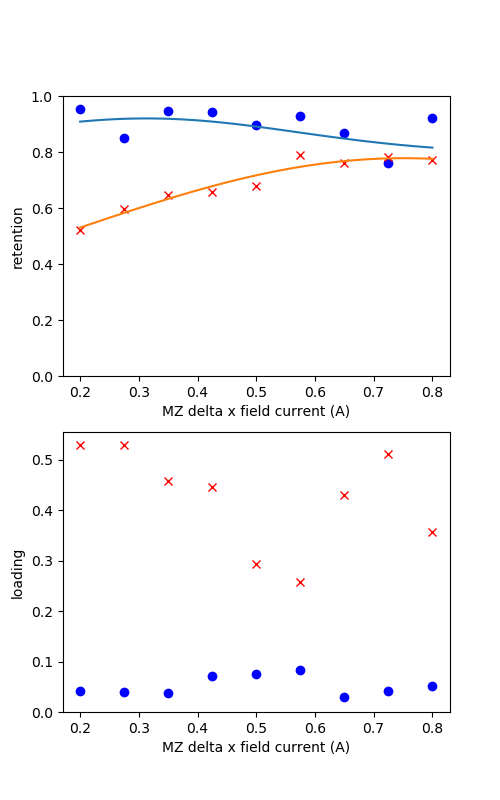

[ 0.12520593  0.31285902  0.25763168  0.7946844 ]
[ 0.67785211  0.75156964 -0.57804709  0.10007162]


In [16]:
exp_name = '2018_01_20_11_40_32_cs-rb-dual-ret-s1'
if exp_name:
    exp_date = '_'.join(exp_name.split('_')[:3])
    experiment_file = os.path.join(exp_date, exp_name, 'results.hdf5')
else:
    experiment_file = ''
q = qdp.QDP(base_data_path=dp)
q.load_data_file(experiment_file)
print "ivars: {}".format(q.experiments[0]['variable_list'])
cs_cuts = [[10],[2]]
rb_cuts = [[10],[3]]
q.set_thresholds(cs_cuts, roi=0)
q.set_thresholds(rb_cuts, roi=1)
retention = q.apply_thresholds()
cuts = q.get_thresholds()
roi_map = ['cs', 'rb']
fmt_map = ['bo', 'rx']
entries = np.product(retention['retention'].shape[:-1])
tbl_str = "ivar: {0:.4f}\tcloading: {1:.3f}\trloading: {2:.3f}\t\tcretention: {3:.3f} +- {4:.3f}\trretention: {5:.3f} +- {6:.3f}"
for i in range(entries):
    print(tbl_str.format(
        retention['ivar'].reshape((entries,-1))[i][0],
        retention['loading'].reshape((entries,-1))[i][0], retention['loading'].reshape((entries,-1))[i][1],
        retention['retention'].reshape((entries,-1))[i][0], retention['error'].reshape((entries,-1))[i][0],
        retention['retention'].reshape((entries,-1))[i][1], retention['error'].reshape((entries,-1))[i][1]
    ))
q.save_experiment_data()
xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']

# plotting
fig, ax = plt.subplots(nrows=2, figsize=(5,8))
plt.subplots_adjust(wspace=0.3)
for i, yvals in enumerate(['retention', 'loading']):
    for e in range(len(retention['ivar'])):
        for r in range(2):
            ax[i].plot(retention['ivar'][e, :, 0], retention[yvals][e, :, r], fmt_map[r])
            if yvals=='retention':
                # fitting
                xs = np.linspace(min(retention['ivar'][e, :, 0]), max(retention['ivar'][e, :, 0]),100)
                guess = [0.3, np.mean(xs), 0.02, 0.1]
                try:
                    popt, pcov = optimize.curve_fit(
                        gaussian,
                        retention['ivar'][e, :, 0],
                        retention[yvals][e, :, r],
                        p0=guess,
                        sigma=retention['error'][e, :, r]
                    )
                except Exception as e:
                    print e
                else:
                    ax[i].plot(xs, gaussian(xs, *popt))
                    print(popt)
        
    ax[i].set_ylim(0, 1.05*np.nanmax(retention[yvals]))
    ax[i].set_xlabel(xlab)
    ax[i].set_ylabel(yvals)

fmts = ['pdf', 'png']
fn = os.path.join(dp, os.path.dirname(experiment_file), 'loading_scan.{}')
for fmt in fmts:
    fig.savefig(fn.format(fmt), dpi=200, format=fmt)

<IPython.core.display.Javascript object>


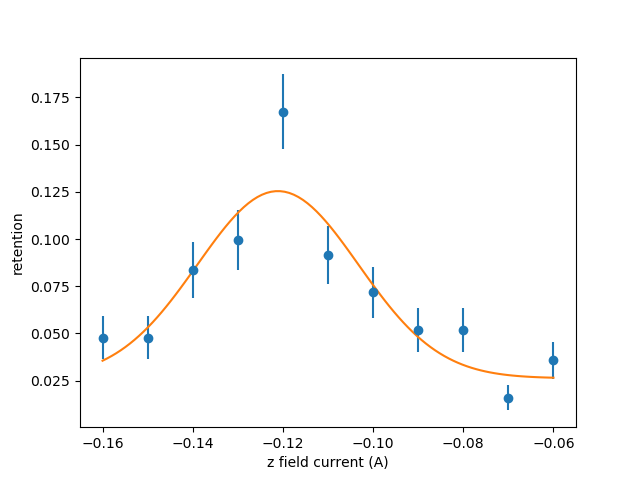

[ 0.09906858 -0.12110532  0.01787537  0.02630579]


In [35]:
fig, ax = plt.subplots()
for e in range(len(retention['ivar'])):
    ax.errorbar(retention['ivar'][e], retention['retention'][e],
                yerr=retention['error'][e],
                fmt = 'o'
    )
#ax.set_ylim(-0.01, 0.3)
ax.set_xlabel(xlab)

guess = [0.1, -0.11, 0.005, 0.0]
for e in range(len(retention['ivar'])):
    popt, pcov = optimize.curve_fit(
        gaussian,
        retention['ivar'][e],
        retention['retention'][e],
        p0=guess,
        sigma=retention['error'][e]
    )
    xs = np.linspace(min(retention['ivar'][e]),max(retention['ivar'][e]),100)
    ax.plot(xs, gaussian(xs, *popt))
    fit_data = "a: {:.3f}\nx0: {:.4f}\ns: {:.3f}\nb: {:.3f}"
    ax.text(0.01, 0.7, fit_data.format(*popt), fontsize=12)

ax.set_ylabel('retention')
print(popt)
fmts = ['pdf', 'png']
fn = os.path.join(dp, os.path.dirname(experiment_file), 'gaussian_retention_fit.{}')
for fmt in fmts:
    fig.savefig(fn.format(fmt), dpi=200, format=fmt)